# 10_monkey 분류

## 1. 디렉토리 설정

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

In [2]:
cd gdrive/My Drive/10-monkeys

/content/gdrive/My Drive/10-monkeys


## 2. 패키지 불러오기

In [3]:
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras import backend as K

Using TensorFlow backend.


In [4]:
K.set_learning_phase(0)

In [0]:
train_dir = 'training/training'
test_dir = 'validation/validation'

### 레이블 이름 및 이미지 개수 확인

In [6]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


## 3. 제너레이터 활용

In [7]:
height = 150
width = 150
channels=3
batch_size=32
seed=123


train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Training generator
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle = True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle = False,
                                                  class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


## 4. 모델링

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization()) 
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization()) 
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(layers.Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 70, 70, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 35, 35, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 33, 64)       

## 5. 모델 학습하기

In [0]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
train_num = train_generator.samples
validation_num = test_generator.samples 

### 학습 조기 종료 지정

In [0]:
early_stop = [EarlyStopping(monitor = 'val_acc', patience = 30)]

In [19]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=250,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=early_stop, 
                              verbose = 1
                             )

Epoch 1/250
34/34 [==============================] - 41s 1s/step - loss: 3.4002 - acc: 0.1445 - val_loss: 2.1771 - val_acc: 0.2031
Epoch 2/250
34/34 [==============================] - 38s 1s/step - loss: 2.2427 - acc: 0.1942 - val_loss: 2.3840 - val_acc: 0.2266
Epoch 3/250
34/34 [==============================] - 37s 1s/step - loss: 2.0723 - acc: 0.2663 - val_loss: 2.1530 - val_acc: 0.2383
Epoch 4/250
34/34 [==============================] - 39s 1s/step - loss: 2.0143 - acc: 0.2941 - val_loss: 2.0686 - val_acc: 0.2891
Epoch 5/250
34/34 [==============================] - 42s 1s/step - loss: 2.0018 - acc: 0.2852 - val_loss: 1.9643 - val_acc: 0.2778
Epoch 6/250
34/34 [==============================] - 35s 1s/step - loss: 1.8849 - acc: 0.2993 - val_loss: 1.9581 - val_acc: 0.2734
Epoch 7/250
34/34 [==============================] - 36s 1s/step - loss: 1.8961 - acc: 0.2974 - val_loss: 1.7553 - val_acc: 0.3984
Epoch 8/250
34/34 [==============================] - 39s 1s/step - loss: 1.8653 - a

## 6. 학습 과정 시각화

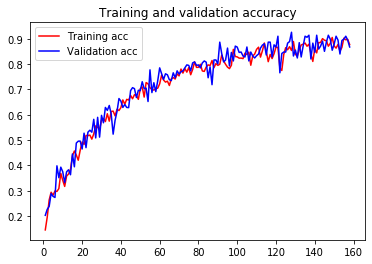

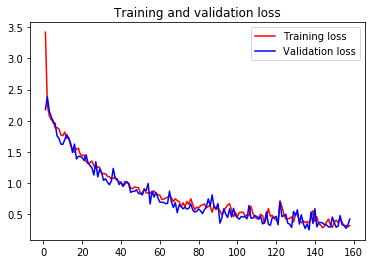

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

## 7. 예측 결과 시각화

In [0]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

In [22]:
model.evaluate_generator(test_generator)

[0.7854410786839092, 0.8198529411764706]

In [0]:
Y_pred = model.predict_generator(test_generator, validation_num // batch_size+1)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(y_true = test_generator.classes,y_pred = Y_pred_classes)

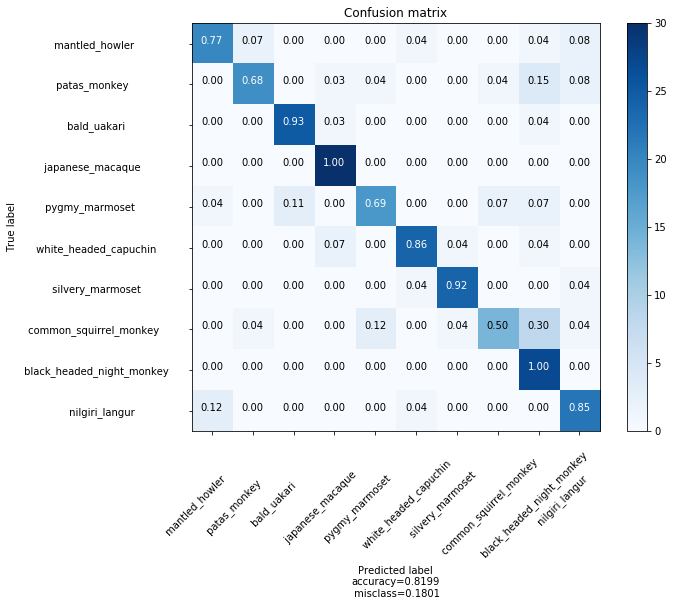

In [24]:
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels['Common Name'])